# Programming Exercise 3 - Multi-class Classification and Neural Networks

#### Import the required libraries

In [10]:
# Data processing
import numpy as np

# Matlab file parsing
from scipy.io import loadmat

# Optimization (GD)
from scipy.optimize import minimize

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('notebook')
sns.set_style('white')

#### Import the MNIST dataset

In [3]:
''' The data is comprised of:
 X - 5000 examples of 20*20 grayscaled (luminosity)
     Shape (5000, (20*20)) : (5000, 400)
 Y - 5000 labels {0: 10, 1:1, 2:2 , ....} there is no zero-index.
     Shape (5000, 1)
'''
data = loadmat("data/ex3data1")

X = np.c_[np.ones((data['X'].shape[0], 1)), data['X']]
y = data['y'] 

print(data.keys())
print("Training set data: ", X[:, 1:].shape)
print("Label set data: {} ". format(y.shape))
print("Trainin data with intercept: ", X.shape)

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
Training set data:  (5000, 400)
Label set data: (5000, 1) 
Trainin data with intercept:  (5000, 401)


#### Sample Feature Display

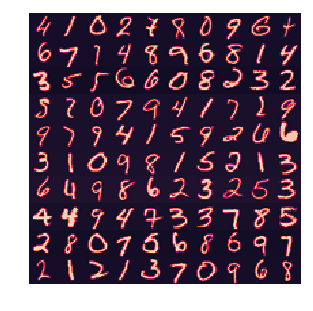

In [4]:
# Extract 100 random samples
sampleDataIndeces = np.random.choice(X.shape[0], 100)

# Plot the selected features
figure, axes = plt.subplots(int(sampleDataIndeces.shape[0] * 0.1), 1, figsize=(15,5))
[ax.set_axis_off() for ax in axes.ravel()]

for i in range(10, (sampleDataIndeces.shape[0] +1), 10):
    axes[(int(i/10) -1)].imshow(X[sampleDataIndeces[max(i-10, 0):i], 1:].reshape(-1, 20).T)
   
plt.subplots_adjust(wspace=0, hspace=0)

### Multiclass Logistic Regression

#### Logistic Regression Hypothesis

\begin{align}
h_{\theta}=g(\theta^{T}x)
\end{align}

\begin{align}
g(z)= \frac{1}{1+e^{-z}}
\end{align}

In [5]:
def sigmoid(z : np.ndarray) -> np.ndarray:
    '''
    Performs an element-wise sigmoidal transformation on the given argument.
    @arg z (np.ndarray) - The target variable to be transformed
    @return (copy) - A copy of the transformed variable
    '''
    return (1 / (1 + np.exp(-z)))

#### Regularized Logistic Cost Function

\begin{align}
J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\big[-y^{(i)}\, log\,( h_\theta\,(x^{(i)}))-(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big] + \frac{\lambda}{2m}\sum^{n}_{j=1}\theta^{2}_{j}
\end{align}

#### Vectorized Regularized Logistic Cost Function

\begin{align}
J(\theta) = \frac{1}{m}(log(g(X\theta))^{T}y+(log(1-g(X\theta))^{T}(1-y))+\frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}
\end{align}

In [6]:
def lrCostFunction(theta: np.ndarray, features: np.ndarray, predictor: np.ndarray, regCoeff: float) -> float :
    '''
    Computes the Regularized Logistic Cost Function for the supplied arguments.
    @arg theta (np.nadarray) - The model's weights
    @arg regCoeff (float) - The regularization coefficient
    @arg features (np.ndarray) - The dataset to be learnt
    @arg predictor (np.ndarray) - The predictor set
    @return (float) - The cost function's value.
    '''
    m = features.shape[0]
    h = sigmoid(features.dot(theta))
    
    J = -1 * (1/m) * (np.log(h).T.dot(predictor) + (np.log(1-h)).T.dot(1-predictor)) + (regCoeff/(2*m))*np.sum(np.square(theta[1:]))

    return np.inf if np.isnan(J[0]) else J[0]  

In [7]:
def lrCostFunctionGrad(theta: np.ndarray, features: np.ndarray, predictor: np.ndarray, regCoeff: float) -> float :
    '''
    Computes the gradient for the supplied dataset and weights
    @arg theta (np.ndarray) - The model's weights
    @arg features (np.ndarray) - The dataset to be learnt
    @arg predictor (np.ndarray) - The predictor set
    @arg regCoeff (float) - The regularization coefficient
    @return (float) - The gradient value.
    
    '''
    m = features.shape[0]
    h = sigmoid(features.dot(theta.reshape(-1,1)))
    grad = (1/m) * features.T.dot(h-predictor) + (regCoeff/m)*np.r_[[[0]], theta[1:].reshape(-1,1)]
    
    return grad.flatten()

#### One-vs-all Classification

In [8]:
def onevsAllClassifier(features: np.ndarray, classes: np.ndarray, num_labels: int, regCoeff: float) -> np.ndarray:
    '''
    Performs a one vs all classification.
    @arg features (np.ndarray) - The dataset to be learnt
    @arg predictor (np.ndarray) - The predictor set
    @arg num_labels (float) - The number of labels
    @arg regCoeff (float) - The regularization coefficient
    @return (np.ndarray)- The optimized weights shape(num_labels, features.shape[0])
    '''
    init_theta = np.zeros((X.shape[1], 1))
    theta_history = np.zeros((num_labels, X.shape[1]))

    for label in np.arange(1, num_labels+1):
        res = minimize(lrCostFunction, init_theta, args=(features, (classes == label)*1, regCoeff), method=None, 
                       jac=lrCostFunctionGrad, options={'maxiter': 50});
        theta_history[label-1] = res.x
        
    return (theta_history)

In [9]:
%%time

classifierTheta = onevsAllClassifier(X, y, 10, 0.1)

Wall time: 15.7 s


#### One-vs-all Prediction

In [60]:
def onevsAllPredict(features: np.ndarray, theta: np.ndarray) -> int:
    '''
    Performs prediction for a one vs all classification.
    @arg features (np.ndarray) - The dataset to be predicted
    @arg theta (np.ndarray) - The optimized weights to be employed
    @return (int)- The predicted label shape(features)
    '''
    
    classProbability = sigmoid(features.dot(theta.T))
    
    return np.argmax(classProbability, axis=1)+1

In [63]:
print("Training accuracy: {}%".format(np.mean(onevsAllPredict(X, classifierTheta) == y.ravel())*100))

Training accuracy: 93.24%


### Neural Networks

#### Import the precomputed weights

In [75]:
weights = loadmat("data/ex3weights.mat")
weights.keys()

#(25, 401), (10, 26)
# 400 input (20*20) + bias; 25 hidden layer; 10 output layer
theta1, theta2 = weights['Theta1'], weights['Theta2']

#### Feedforward Neural Network (Pre-Trained)

In [96]:
def nnPredict(features: np.ndarray, weights_1: np.ndarray, weights_2: np.ndarray) -> int:
    '''
    Performs classification prediction on a feedforward neural-network with 1 hideen layer.
    @arg features (np.ndarray) - The dataset to be predicted
    @arg weights_1 (np.ndarray) - The optimized weights to be employed on the hidden layer
    @arg weights_2 (np.ndarray) - The optimized weights to be employed on the output layer
    @return (int)- The predicted label shape(features)
    '''
    
    hlayer1 = weights_1.dot(features.T)
    activated_1 = np.c_[np.ones((X.shape[0],1)), sigmoid(hlayer1).T]
    
    hlayer2 = activated_1.dot(weights_2.T)
    activated_2 = sigmoid(hlayer2)
    
    return np.argmax(activated_2, axis=1)+1

In [95]:
print("fNN Training accuracy: {}%".format(np.mean(nnPredict(X, theta1, theta2) == y.ravel()) *100))

fNN Training accuracy: 97.52%
